In [2]:
!pip install torch torchvision tqdm torchinfo numpy pandas matplotlib seaborn Pillow

In [3]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from IPython.display import display
from PIL import Image

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

print(f'Torch Verison: {torch.__version__}')
print(f'Torchvision Verison: {torchvision.__version__}')

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Torch Verison: 1.11.0
Torchvision Verison: 0.12.0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
train_transform = transforms.Compose([
#     transforms.RandomRotation(degrees=20),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.RandomAffine(degrees=0, scale=(0.5, 1.3)),
#     transforms.RandomAffine(degrees=0, shear=(-5, 5, -5, 5)),
#     transforms.RandomInvert(p=0.3),
    # transforms.RandomApply([
    #     transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)),
    # ], p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(0.1307, 0.3081) # mean and std of mnist dataset
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(0.1307, 0.3081)
])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=train_transform)
valid_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, transform=test_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



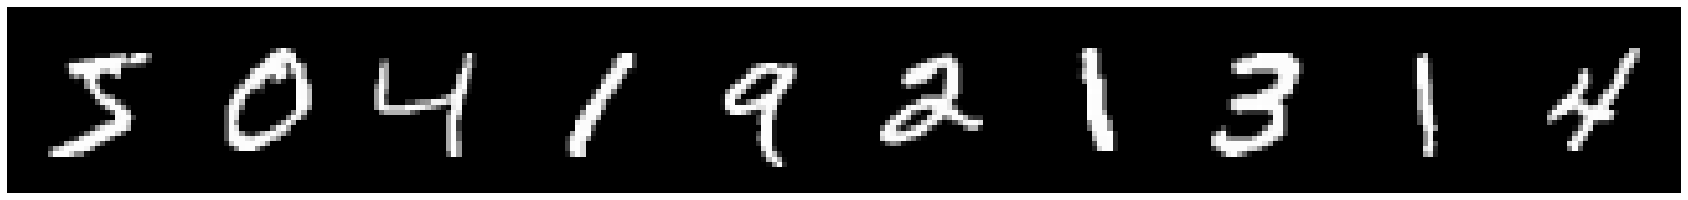

['5 - five', '0 - zero', '4 - four', '1 - one', '9 - nine', '2 - two', '1 - one', '3 - three', '1 - one', '4 - four']


In [7]:
images, labels = zip(*[train_dataset[i] for i in range(10)])
images = torch.stack(images)

grid = torchvision.utils.make_grid(images, nrow=10, padding=4)

fig, ax = plt.subplots(figsize=(30, 30))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()
print([train_dataset.classes[label] for label in labels])

In [8]:
EPOCHS = 32
BATCH_SIZE = 64
LEARNING_RATE = 3e-4 # karapathy constant
CHANNELS = 1
LATENT_DIM = 32
WIDTH = 28
HEIGHT = 28
WEIGHT_DECAY = 1e-6

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

tensor(0.) tensor(1.)


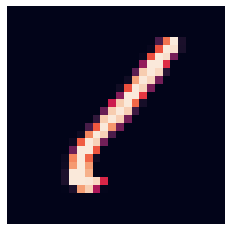

In [10]:
train_iter = iter(train_loader)
images, labels = next(train_iter)

print(torch.min(images), torch.max(images))

plt.axis('off')
plt.imshow(transforms.ToPILImage()(images[0]))

In [11]:
class Encoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, stride=2, padding=3, dilation=1, bias=True, padding_mode='zeros'), # N, 16, 16, 16
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 8, 8
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 4, 4
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4), # N, latent_dim, 1, 1
            nn.LeakyReLU(inplace=True)
        )
        
        self.linear = nn.Linear(in_features=64, out_features=latent_dim)

    def forward(self, x):
        x = self.net(x)

        '''
            It is common practice to not use an activation function in the last layer of the encoder in an autoencoder. 
            This is because the last layer of the encoder should output a representation that captures the essential features of the input data, 
            and an activation function could distort this representation by introducing non-linearity.
        '''
        
        x = torch.flatten(x, 1)
        logits = self.linear(x)

        return logits

summary(model=Encoder(channels=CHANNELS, latent_dim=LATENT_DIM), input_size=[BATCH_SIZE, CHANNELS, WIDTH, HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [64, 32]                  --
├─Sequential: 1-1                        [64, 64, 1, 1]            --
│    └─Conv2d: 2-1                       [64, 16, 16, 16]          160
│    └─LeakyReLU: 2-2                    [64, 16, 16, 16]          --
│    └─Conv2d: 2-3                       [64, 16, 8, 8]            2,320
│    └─LeakyReLU: 2-4                    [64, 16, 8, 8]            --
│    └─Conv2d: 2-5                       [64, 32, 4, 4]            4,640
│    └─LeakyReLU: 2-6                    [64, 32, 4, 4]            --
│    └─Conv2d: 2-7                       [64, 64, 1, 1]            32,832
│    └─LeakyReLU: 2-8                    [64, 64, 1, 1]            --
├─Linear: 1-2                            [64, 32]                  2,080
Total params: 42,032
Trainable params: 42,032
Non-trainable params: 0
Total mult-adds (M): 19.11
Input size (MB): 0.20
Forward/backward pass 

In [12]:
class Decoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(Decoder, self).__init__()
        
        self.linear = nn.Linear(in_features=latent_dim, out_features=64)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4, 4), stride=1, padding=0, dilation=1, bias=True, padding_mode='zeros'), # N, 32, 4, 4
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 7, 7 -> with output_padding=1 we get N, 16, 8, 8
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 16, 16
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=channels, kernel_size=3, stride=2, padding=3, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid() # as we have normalized the dataset, so our range is from [0, 1], so we want sigmoid, if it had been [-1, 1], i.e, mean=0.5 and std=0.5 we would have used tanh
        )

    def forward(self, x):
        x = F.relu(self.linear(x))

        x = x.view(x.shape[0], -1, 1, 1)
        x = self.net(x)
        
        return x

# if we use MaxPool2d, we have to use MaxUnpool2d
# if dataset is in range of [-1, 1], consider using leaky-relu 

summary(model=Decoder(channels=CHANNELS, latent_dim=LATENT_DIM), input_size=[BATCH_SIZE, LATENT_DIM])

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 1, 28, 28]           --
├─Linear: 1-1                            [64, 64]                  2,112
├─Sequential: 1-2                        [64, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-1              [64, 32, 4, 4]            32,800
│    └─LeakyReLU: 2-2                    [64, 32, 4, 4]            --
│    └─ConvTranspose2d: 2-3              [64, 16, 8, 8]            4,624
│    └─LeakyReLU: 2-4                    [64, 16, 8, 8]            --
│    └─ConvTranspose2d: 2-5              [64, 16, 16, 16]          2,320
│    └─LeakyReLU: 2-6                    [64, 16, 16, 16]          --
│    └─ConvTranspose2d: 2-7              [64, 1, 28, 28]           145
│    └─Sigmoid: 2-8                      [64, 1, 28, 28]           --
Total params: 42,001
Trainable params: 42,001
Non-trainable params: 0
Total mult-adds (M): 97.95
Input size (MB): 0.01
Forward/backward pass 

In [13]:
# AutoEncoders are also a type of generative model
class AutoEncoder(nn.Module):
    def __init__(self, channels, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(channels, latent_dim).to(device)
        self.decoder = Decoder(channels, latent_dim).to(device)
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat

summary(model=AutoEncoder(channels=CHANNELS, latent_dim=LATENT_DIM), input_size=[BATCH_SIZE, CHANNELS, WIDTH, HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [64, 1, 28, 28]           --
├─Encoder: 1-1                           [64, 32]                  --
│    └─Sequential: 2-1                   [64, 64, 1, 1]            --
│    │    └─Conv2d: 3-1                  [64, 16, 16, 16]          160
│    │    └─LeakyReLU: 3-2               [64, 16, 16, 16]          --
│    │    └─Conv2d: 3-3                  [64, 16, 8, 8]            2,320
│    │    └─LeakyReLU: 3-4               [64, 16, 8, 8]            --
│    │    └─Conv2d: 3-5                  [64, 32, 4, 4]            4,640
│    │    └─LeakyReLU: 3-6               [64, 32, 4, 4]            --
│    │    └─Conv2d: 3-7                  [64, 64, 1, 1]            32,832
│    │    └─LeakyReLU: 3-8               [64, 64, 1, 1]            --
│    └─Linear: 2-2                       [64, 32]                  2,080
├─Decoder: 1-2                           [64, 1, 28, 28]           --
│

In [14]:
autoencoder = AutoEncoder(channels=CHANNELS, latent_dim=LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=16, gamma=0.1)

In [15]:
for epoch in tqdm(range(EPOCHS)):
    autoencoder.train()

    train_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        autoencoder.zero_grad()

    scheduler.step()

    autoencoder.eval()

    valid_loss = 0.0
    with torch.inference_mode():
        for images, _ in valid_loader:
            images = images.to(device)

            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            valid_loss += loss.item()

    if not (epoch + 1) % 10 or epoch == EPOCHS - 1:
        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 12.4430, Valid Loss: 1.9780
Epoch: 20, Train Loss: 8.8343, Valid Loss: 1.4462
Epoch: 30, Train Loss: 8.3951, Valid Loss: 1.3756
Epoch: 32, Train Loss: 8.3143, Valid Loss: 1.3630


torch.Size([1, 32])


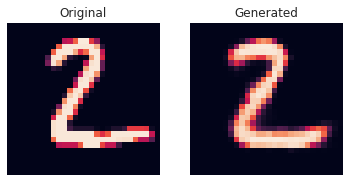

In [52]:
valid_iter = iter(valid_loader)
images, _ = next(valid_iter)

rand_im = torch.randint(low=0, high=BATCH_SIZE, size=(1,)).item()

img = images[rand_im]

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(transforms.ToPILImage()(img))

# Generated

encoder = autoencoder.encoder
decoder = autoencoder.decoder

img = img.unsqueeze(dim=0).to(device) # unsqueeze because we have passed a batch of inputs to trained model

print(encoder(img).shape)
gen_img = decoder(encoder(img))
gen_img = gen_img.squeeze()

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Generated")
plt.imshow(transforms.ToPILImage()(gen_img))

tensor([[0.1888, 0.9434, 0.2720, 0.2248, 0.7225, 0.3716, 0.4147, 0.3428, 0.4682,
         0.1593, 0.3065, 0.6904, 0.0748, 0.3358, 0.9790, 0.3890, 0.6870, 0.2086,
         0.1448, 0.8760, 0.8581, 0.4756, 0.3448, 0.7308, 0.5028, 0.5572, 0.8154,
         0.0548, 0.3392, 0.8210, 0.8199, 0.4953]], device='cuda:0')


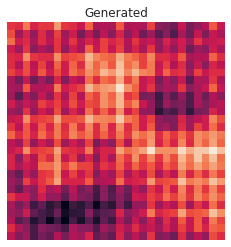

In [44]:
# generate from random latent space vector
rand = torch.rand((1, 32)).to(device)
print(rand)

gen_img = decoder(rand)
gen_img = gen_img.squeeze()

plt.axis('off')
plt.title("Generated")
plt.imshow(transforms.ToPILImage()(gen_img))